# Lib Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from hcdr.modeling.preproc import preproc_pipeline
from hcdr.data.merged_data import merge_dfs
from sklearn.model_selection import train_test_split

In [2]:
from sklearn import set_config; set_config(display='diagram')

%load_ext autoreload
%autoreload 2

# Get Merged df

In [3]:
"""Code to create new df_merged df"""
# %%time
# df_merged = merge_dfs(df_app="application_train", verbose=True)
# df_merged_test = merge_dfs(df_app="application_test", verbose=True)

'Code to create new df_merged df'

In [4]:
# Use instead of running script to create merged df everytime.
"""Save df_merged"""
df_merged_path = "../raw_data/df_merged.pkl"
df_merged_test_path = "../raw_data/df_merged_test.pkl"

# df_merged.to_pickle(df_merged_path)
# df_merged_test.to_pickle(df_merged_test_path)

"""Load df_merged"""
df_merged = pd.read_pickle(df_merged_path)
df_merged_test = pd.read_pickle(df_merged_test_path)


In [5]:
# df_merged = df_merged.replace(to_replace=np.inf,value=np.nan).replace(to_replace=-np.inf,value=np.nan)

# X & y

In [10]:
X_train = df_merged.drop(columns=["SK_ID_CURR", "TARGET"])
y_train = df_merged["TARGET"]

X_test = df_merged_test.drop(columns=["SK_ID_CURR"])

del df_merged
del df_merged_test

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

# Preprocess df

In [12]:
# Use standard scaler for DL:
preproc = preproc_pipeline(scaler_type="standard")
preproc

Running preprocessor...
scaler_type=standard


Pipeline(steps=[('preprocessor1',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a440bdac0>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a440bdfd0>)])),
                ('scaler', StandardScaler())])

## fit and transform X

In [13]:
preproc.fit(X_train)
X_train_xformed = preproc.transform(X_train)
del X_train

X_val_xformed = preproc.transform(X_val)
del X_val

X_test_xformed = preproc.transform(X_test)
del X_test

In [14]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.2, replacement=True)
X_train_xformed_under, y_train_under = undersample.fit_resample(X_train_xformed, y_train)

In [15]:
X_train_xformed.shape, X_train_xformed_under.shape, X_val_xformed.shape

((215257, 691), (104514, 691), (92254, 691))

In [16]:
y_train_under.value_counts()

0    87095
1    17419
Name: TARGET, dtype: int64

In [17]:
y_train_under.value_counts(normalize=True)

0    0.833333
1    0.166667
Name: TARGET, dtype: float64

# Model Setup

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

Kaggle metric is ROC_AUC.

In [5]:
def initialize_model(input_dim):
    """"""
    model = models.Sequential()

    model.add(layers.Dense(16, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    ### Model optimization : Optimizer, loss and metric 
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(), # "binary_crossentropy"
                  metrics=[tf.keras.metrics.AUC(), "accuracy"]) # "accuracy"
    return model

input_dim = X_train_xformed.shape[1]
model = initialize_model(input_dim)
model.summary()

NameError: name 'X_train_xformed' is not defined

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
es = EarlyStopping(patience=2)

In [23]:
history = model.fit(X_train_xformed_under, y_train_under,
                    validation_data=(X_val_xformed, y_val),
                    epochs=1_000, 
                    batch_size=64, 
                    verbose=1,
                    callbacks=[es]
                    )

Epoch 1/1000
1634/1634 [==============================] - 15s 9ms/step - loss: 0.4223 - auc: 0.7040 - accuracy: 0.8276 - val_loss: 0.2873 - val_auc: 0.7320 - val_accuracy: 0.9152
Epoch 2/1000
1634/1634 [==============================] - 5s 3ms/step - loss: 0.3968 - auc: 0.7436 - accuracy: 0.8354 - val_loss: 0.2820 - val_auc: 0.7392 - val_accuracy: 0.9146
Epoch 3/1000
1634/1634 [==============================] - 5s 3ms/step - loss: 0.3919 - auc: 0.7519 - accuracy: 0.8374 - val_loss: 0.2790 - val_auc: 0.7369 - val_accuracy: 0.9159
Epoch 4/1000
1634/1634 [==============================] - 4s 3ms/step - loss: 0.3896 - auc: 0.7558 - accuracy: 0.8380 - val_loss: 0.2758 - val_auc: 0.7374 - val_accuracy: 0.9145
Epoch 5/1000
1634/1634 [==============================] - 4s 3ms/step - loss: 0.3868 - auc: 0.7608 - accuracy: 0.8389 - val_loss: 0.2848 - val_auc: 0.7429 - val_accuracy: 0.9115
Epoch 6/1000
1634/1634 [==============================] - 4s 3ms/step - loss: 0.3848 - auc: 0.7645 - accuracy

In [31]:
from pickle import dump
from pickle import load

In [29]:
import pickle

In [30]:
preproc_filepath = "../modeling/prepocesor.pkl"
dump(preproc, open(preproc_filepath, 'wb'))

In [33]:
load(open(preproc_filepath, 'rb'))

Pipeline(steps=[('preprocessor1',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f89c164e940>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f89c164efa0>)])),
                ('scaler', StandardScaler())])

In [ ]:
pd.DataFrame().to_feather()

In [44]:
model_path = "../modeling/tf_model"
model.save(filepath=model_path)

INFO:tensorflow:Assets written to: ../modeling/tf_model/assets


In [45]:
loaded_model = tf.keras.models.load_model(model_path)

In [27]:
loaded_model.predict(X_val_xformed)

array([[0.48013777],
       [0.09331658],
       [0.46074903],
       ...,
       [0.05221599],
       [0.19670162],
       [0.2729097 ]], dtype=float32)

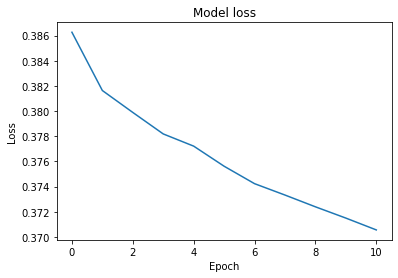

In [84]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_history(history)

Baseline ROC_AUC = 0.5

In [15]:
from sklearn.metrics import roc_auc_score

In [85]:
y_prob = model.predict(X_val_xformed)
roc_auc = roc_auc_score(y_val, y_prob)
roc_auc

0.7367952898918037

Baseline Accuracy:

In [86]:
y_train_under.value_counts(normalize=True)

0    0.833333
1    0.166667
Name: TARGET, dtype: float64

In [87]:
(y_prob>0.5).sum()

3989

Text(0.5, 1.0, 'Precision-Recall Curve')

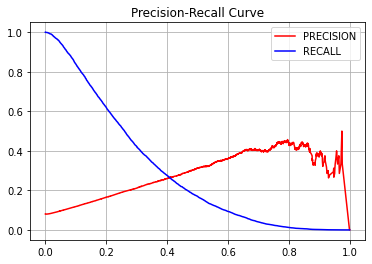

In [88]:
# Plot Precision-Recall curve using sklearn.
from sklearn.metrics import precision_recall_curve
precision, recall, treshold = precision_recall_curve(y_val, y_prob)
  
# Plot the output.
plt.plot(treshold, precision[:-1], c ='r', label ='PRECISION')
plt.plot(treshold, recall[:-1], c ='b', label ='RECALL')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')


# Modeling from Package:

In [49]:
from hcdr.modeling.deep_learning import preprocess_data, train_model

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%time
preprocess_data()

LOADING TRAIN DATA
SPLITTING MERGED DF INTO X and Y...
DELETING MERGED DF FROM MEMORY...
save y_train
Creating the preprocessor...
Running preprocessor...
scaler_type=standard
Fitting the preprocessor...
Transforming X_train thru fitted pre_processor AND deleting original X_train var...
save X_train
LOADING TEST DATA
Transforming X_test thru fitted pre_processor AND deleting original X_test var...
CPU times: user 2min 5s, sys: 2min 41s, total: 4min 47s
Wall time: 8min 12s


In [3]:
import pandas as pd

In [6]:
path_X_train = "../modeling/X_train_xformed.pkl"
path_y_train = "../modeling/y_train.pkl"
X_train = pd.read_pickle(path_X_train)
y_train = pd.read_pickle(path_y_train)


In [8]:
def initialize_model(input_dim):
    """"""
    model = models.Sequential()

    model.add(layers.Dense(16, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    ### Model optimization : Optimizer, loss and metric 
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(), # "binary_crossentropy"
                  metrics=[tf.keras.metrics.AUC(), "accuracy"]) # "accuracy"
    return model

input_dim = X_train.shape[1]
model = initialize_model(input_dim)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                11072     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 11,217
Trainable params: 11,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit()

In [61]:
from hcdr.modeling.deep_learning import preprocess_data, train_model, initialize_model

In [62]:
# from hcdr.modeling.deep_learning import preprocess_data, train_model, initialize_model
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
history = train_model(pre_split=False, validation_split=0.3, undersampling=False)

Loading saved X_train and y_train
Epoch 1/1000
3364/3364 [==============================] - 28s 8ms/step - loss: 0.2707 - auc_8: 0.7017 - accuracy: 0.9174 - val_loss: 0.2554 - val_auc_8: 0.7255 - val_accuracy: 0.9204
Epoch 2/1000
3364/3364 [==============================] - 8s 2ms/step - loss: 0.2554 - auc_8: 0.7357 - accuracy: 0.9187 - val_loss: 0.2500 - val_auc_8: 0.7406 - val_accuracy: 0.9205
Epoch 3/1000
3364/3364 [==============================] - 9s 3ms/step - loss: 0.2523 - auc_8: 0.7432 - accuracy: 0.9187 - val_loss: 0.2492 - val_auc_8: 0.7438 - val_accuracy: 0.9204
Epoch 4/1000
3364/3364 [==============================] - 8s 2ms/step - loss: 0.2504 - auc_8: 0.7496 - accuracy: 0.9187 - val_loss: 0.2476 - val_auc_8: 0.7502 - val_accuracy: 0.9205
Epoch 5/1000
3364/3364 [==============================] - 8s 2ms/step - loss: 0.2492 - auc_8: 0.7533 - accuracy: 0.9187 - val_loss: 0.2483 - val_auc_8: 0.7460 - val_accuracy: 0.9204
Epoch 6/1000
3364/3364 [==============================]

In [48]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_36 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 10        
Total params: 774
Trainable params: 774
Non-trainable params: 0
_________________________________________________________________


In [47]:
history.history["val_auc_8"][-1]

0.748184084892273

In [ ]:
# Plot Precision-Recall curve using sklearn.
from sklearn.metrics import precision_recall_curve
precision, recall, treshold = precision_recall_curve(y_val, y_prob)
  
# Plot the output.
plt.plot(treshold, precision[:-1], c ='r', label ='PRECISION')
plt.plot(treshold, recall[:-1], c ='b', label ='RECALL')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')


In [41]:
layers.Dense(neurons, activation='relu', input_dim=input_dim, kernel_regularizer=tf.keras.regularizers.l2(l2=0.01), kernel_initializer="he_normal")
rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.1,
                                        patience=10)

NameError: name 'input_dim' is not defined

In [42]:
def initialize_model(neurons_list, input_dim=1):
    """"""
    model = models.Sequential()
    
    for i, neurons in enumerate(neurons_list):
        if i==0:
            model.add(layers.Dense(neurons, activation='relu',
                                   input_dim=input_dim,
                                   kernel_regularizer=tf.keras.regularizers.l2(l2=0.01), # regularizes the learning rate
                                   kernel_initializer="he_normal")) # how the initial weights are randomly generated
            
            print(f"added layer {i} with {neurons} neurons. input_dim={input_dim}")
            continue
        else:
            model.add(layers.Dense(neurons, activation='relu'))
            print(f"added layer {i} with {neurons} neurons.")
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    ### Model optimization : Optimizer, loss and metric 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(), # "binary_crossentropy"
                  metrics=[tf.keras.metrics.AUC(), "accuracy"]) # "accuracy"
    return model

initialize_model(neurons_list, input_dim=1)

added layer 0 with 16 neurons. input_dim=1
added layer 1 with 32 neurons.
added layer 2 with 8 neurons.
added layer 3 with 8 neurons.


In [25]:
neurons_list = [32, 16, 8, 4, 2]
neurons_list

[32, 16, 8, 4, 2]

In [13]:
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

In [34]:
dict_of_models_neurons_list = {"model_1": [16],
"model_2": [32, 8, 2],
"model_3": [16, 16, 16, 4],
"model_4": [64, 2],
"model_5": [16, 32, 8, 8]
}

In [35]:
dict_models = {}
for key, neurons_list in dict_of_models_neurons_list.items():
    dict_models[key] = initialize_model(neurons_list, input_dim=1)

added layer 0 with 16 neurons. input_dim=1
added layer 0 with 32 neurons. input_dim=1
added layer 1 with 8 neurons.
added layer 2 with 2 neurons.
added layer 0 with 16 neurons. input_dim=1
added layer 1 with 16 neurons.
added layer 2 with 16 neurons.
added layer 3 with 4 neurons.
added layer 0 with 64 neurons. input_dim=1
added layer 1 with 2 neurons.
added layer 0 with 16 neurons. input_dim=1
added layer 1 with 32 neurons.
added layer 2 with 8 neurons.
added layer 3 with 8 neurons.


In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf


In [57]:
path_X_train = "../modeling/X_train_xformed.pkl"
path_y_train = "../modeling/y_train.pkl"

X_train = pd.read_pickle(path_X_train)
y_train = pd.read_pickle(path_y_train)

X_train, X_test_model, y_train, y_test_model = train_test_split(X_train, y_train, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
validation_data=(X_val, y_val)
del X_val
del y_val

In [67]:
model = initialize_model(X_train.shape[1])

patience = 2
es = EarlyStopping(patience=patience, restore_best_weights=True)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience-1,)

history = model.fit(X_train, y_train,
                validation_data=validation_data,
                validation_split=0,
                epochs=1_000, 
                batch_size=64, 
                verbose=1,
                callbacks=[es, rlrp]
                )


added layer 0 with 16 neurons. input_dim=691
added layer 1 with 8 neurons.
Epoch 1/1000
2691/2691 [==============================] - 21s 5ms/step - loss: 0.3067 - auc_12: 0.6885 - accuracy: 0.9165 - val_loss: 0.2661 - val_auc_12: 0.7133 - val_accuracy: 0.9206
Epoch 2/1000
2691/2691 [==============================] - 6s 2ms/step - loss: 0.2687 - auc_12: 0.7178 - accuracy: 0.9188 - val_loss: 0.2662 - val_auc_12: 0.7106 - val_accuracy: 0.9206
Epoch 3/1000
2691/2691 [==============================] - 5s 2ms/step - loss: 0.2676 - auc_12: 0.7187 - accuracy: 0.9188 - val_loss: 0.2634 - val_auc_12: 0.7236 - val_accuracy: 0.9206
Epoch 4/1000
2691/2691 [==============================] - 5s 2ms/step - loss: 0.2660 - auc_12: 0.7240 - accuracy: 0.9188 - val_loss: 0.2626 - val_auc_12: 0.7201 - val_accuracy: 0.9206
Epoch 5/1000
2691/2691 [==============================] - 5s 2ms/step - loss: 0.2652 - auc_12: 0.7255 - accuracy: 0.9188 - val_loss: 0.2643 - val_auc_12: 0.7109 - val_accuracy: 0.9206
Epoc

Epoch 45/1000
2691/2691 [==============================] - 6s 2ms/step - loss: 0.2501 - auc_12: 0.7575 - accuracy: 0.9188 - val_loss: 0.2495 - val_auc_12: 0.7471 - val_accuracy: 0.9206
Epoch 46/1000
2691/2691 [==============================] - 6s 2ms/step - loss: 0.2501 - auc_12: 0.7574 - accuracy: 0.9188 - val_loss: 0.2495 - val_auc_12: 0.7471 - val_accuracy: 0.9206
Epoch 47/1000
2691/2691 [==============================] - 6s 2ms/step - loss: 0.2501 - auc_12: 0.7574 - accuracy: 0.9188 - val_loss: 0.2495 - val_auc_12: 0.7471 - val_accuracy: 0.9206
Epoch 48/1000
2691/2691 [==============================] - 7s 2ms/step - loss: 0.2501 - auc_12: 0.7575 - accuracy: 0.9188 - val_loss: 0.2495 - val_auc_12: 0.7471 - val_accuracy: 0.9206
Epoch 49/1000
2691/2691 [==============================] - 6s 2ms/step - loss: 0.2501 - auc_12: 0.7574 - accuracy: 0.9188 - val_loss: 0.2495 - val_auc_12: 0.7471 - val_accuracy: 0.9206
Epoch 50/1000
2691/2691 [==============================] - 6s 2ms/step - lo

In [68]:
model.evaluate(X_test_model, y_test_model)

1922/1922 [==============================] - 2s 1ms/step - loss: 0.2516 - auc_12: 0.7513 - accuracy: 0.9189


[0.2515675723552704, 0.7512596845626831, 0.9189307689666748]

In [1]:
from hcdr.modeling.deep_learning import preprocess_data, train_model, predict_test_data
import pandas as pd
%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'predict_test_data' from 'hcdr.modeling.deep_learning' (/home/cmantilla/code/chris14jan/kaggle/package/hcdr/hcdr/modeling/deep_learning.py)

In [2]:
# Test Data
path_X_test_model = "../modeling/data/X_test_model.pkl"
X_test_model = pd.read_pickle(path_X_test_model)
path_y_test_model = "../modeling/data/y_test_model.pkl"
y_test_model = pd.read_pickle(path_y_test_model)
model_test_data = X_test_model, y_test_model
del X_test_model
del y_test_model

# Val Data
path_X_val_model = "../modeling/data/X_val_model.pkl"
X_val_model = pd.read_pickle(path_X_val_model)
path_y_val_model = "../modeling/data/y_val_model.pkl"
y_val_model = pd.read_pickle(path_y_val_model)
model_val_data = X_val_model, y_val_model
del X_val_model
del y_val_model

# Train Data
path_X_train = "../modeling/data/X_train_model.pkl"
X_train = pd.read_pickle(path_X_train)
path_y_train = "../modeling/data/y_train_model.pkl"
y_train = pd.read_pickle(path_y_train)


In [3]:
model_test_data[0].shape

(92254, 691)

In [4]:
X_train.shape

(150679, 691)

In [5]:
dict_of_models_neurons_list = {"model_1": [16, 8, 2],
"model_2": [32, 8, 2],
"model_3": [16, 16, 16, 4],
"model_4": [64, 2],
"model_5": [16, 32, 8, 8]
}


dict_model_info = {}
for key, neurons_list in dict_of_models_neurons_list.items():
    dict_model_info = train_model(X_train, y_train, model_val_data, model_test_data, neurons_list=neurons_list, dict_model_info=dict_model_info)


added layer 0 with 16 neurons. input_dim=691
added layer 1 with 8 neurons.
added layer 2 with 2 neurons.
Epoch 1/1000
1178/1178 [==============================] - 42s 31ms/step - loss: 0.5255 - auc: 0.5048 - accuracy: 0.9157 - val_loss: 0.3951 - val_auc: 0.5000 - val_accuracy: 0.9204
Epoch 2/1000
1178/1178 [==============================] - 3s 2ms/step - loss: 0.3431 - auc: 0.5026 - accuracy: 0.9194 - val_loss: 0.3064 - val_auc: 0.5000 - val_accuracy: 0.9204
Epoch 3/1000
1178/1178 [==============================] - 3s 3ms/step - loss: 0.2938 - auc: 0.5024 - accuracy: 0.9194 - val_loss: 0.2828 - val_auc: 0.5000 - val_accuracy: 0.9204
Epoch 4/1000
1178/1178 [==============================] - 3s 2ms/step - loss: 0.2822 - auc: 0.5030 - accuracy: 0.9194 - val_loss: 0.2783 - val_auc: 0.5000 - val_accuracy: 0.9204
Epoch 5/1000
1178/1178 [==============================] - 3s 3ms/step - loss: 0.2804 - auc: 0.5032 - accuracy: 0.9194 - val_loss: 0.2778 - val_auc: 0.5000 - val_accuracy: 0.9204
Epo

1178/1178 [==============================] - 3s 3ms/step - loss: 0.2472 - auc_2: 0.7626 - accuracy: 0.9194 - val_loss: 0.2491 - val_auc_2: 0.7492 - val_accuracy: 0.9204
Epoch 18/1000
1178/1178 [==============================] - 3s 3ms/step - loss: 0.2471 - auc_2: 0.7628 - accuracy: 0.9194 - val_loss: 0.2490 - val_auc_2: 0.7493 - val_accuracy: 0.9204
Epoch 19/1000
1178/1178 [==============================] - 3s 3ms/step - loss: 0.2470 - auc_2: 0.7631 - accuracy: 0.9194 - val_loss: 0.2490 - val_auc_2: 0.7494 - val_accuracy: 0.9204
Epoch 20/1000
1178/1178 [==============================] - 3s 3ms/step - loss: 0.2469 - auc_2: 0.7632 - accuracy: 0.9194 - val_loss: 0.2491 - val_auc_2: 0.7489 - val_accuracy: 0.9204
Epoch 21/1000
1178/1178 [==============================] - 3s 3ms/step - loss: 0.2468 - auc_2: 0.7636 - accuracy: 0.9194 - val_loss: 0.2490 - val_auc_2: 0.7491 - val_accuracy: 0.9204
Epoch 22/1000
1178/1178 [==============================] - 3s 3ms/step - loss: 0.2467 - auc_2: 0.76

Epoch 34/1000
1178/1178 [==============================] - 3s 3ms/step - loss: 0.2488 - auc_3: 0.7598 - accuracy: 0.9194 - val_loss: 0.2497 - val_auc_3: 0.7489 - val_accuracy: 0.9204
Epoch 35/1000
1178/1178 [==============================] - 3s 3ms/step - loss: 0.2488 - auc_3: 0.7598 - accuracy: 0.9194 - val_loss: 0.2497 - val_auc_3: 0.7489 - val_accuracy: 0.9204
Epoch 36/1000
1178/1178 [==============================] - 4s 3ms/step - loss: 0.2488 - auc_3: 0.7598 - accuracy: 0.9194 - val_loss: 0.2497 - val_auc_3: 0.7489 - val_accuracy: 0.9204
Epoch 37/1000
1178/1178 [==============================] - 4s 3ms/step - loss: 0.2488 - auc_3: 0.7598 - accuracy: 0.9194 - val_loss: 0.2497 - val_auc_3: 0.7489 - val_accuracy: 0.9204
Epoch 38/1000
1178/1178 [==============================] - 4s 3ms/step - loss: 0.2488 - auc_3: 0.7598 - accuracy: 0.9194 - val_loss: 0.2497 - val_auc_3: 0.7489 - val_accuracy: 0.9204
Epoch 39/1000
2883/2883 [==============================] - 3s 1ms/step - loss: 0.2549

In [3]:
predict_test_data()

[autoreload of hcdr.modeling.deep_learning failed: Traceback (most recent call last):
  File "/home/cmantilla/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/cmantilla/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/cmantilla/.pyenv/versions/3.8.6/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/cmantilla/.pyenv/versions/3.8.6/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/cmantilla/code/chris14jan/kaggle/package/hcdr/hcdr/modeling/dee

2883/2883 [==============================] - 11s 4ms/step - loss: 0.2828 - auc: 0.5000 - accuracy: 0.9183


KeyboardInterrupt: 

In [2]:
dict_of_models_neurons_list = {"model_1": [16, 8, 2],
"model_2": [32, 8, 2],
"model_3": [16, 16, 16, 4],
"model_4": [64, 2],
"model_5": [16, 32, 8, 8]
}
for i in range(1, len(dict_of_models_neurons_list)+1):
    print(i, predict_test_data(i)[2])

2883/2883 [==============================] - 5s 1ms/step - loss: 0.2828 - auc: 0.5000 - accuracy: 0.9183
1 [0.07998532]
2883/2883 [==============================] - 4s 1ms/step - loss: 0.2541 - auc_4: 0.7460 - accuracy: 0.9183
2 [0.02888796]


OSError: SavedModel file does not exist at: ../modeling/tf_model_3.h5/{saved_model.pbtxt|saved_model.pb}

In [7]:
import tensorflow as tf

In [8]:
for i in range(1, 5+1):
    print(i)

1
2
3
4
5


In [ ]:
import pandas as pd

In [ ]:
pd.read_csv()

In [ ]:
from hcdr.modeling.deep_learning import preprocess_data, train_model, predict_test_data
import pandas as pd
%load_ext autoreload
%autoreload 2

In [ ]:
preprocess_data(scaler_type=None)

LOADING TRAIN DATA
SPLITTING MERGED DF INTO X and Y...
DELETING MERGED DF FROM MEMORY...
save y_train
Creating the preprocessor...
Running preprocessor...
scaler_type=None
Fitting the preprocessor...
